In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from glob import glob
from sklearn.model_selection import train_test_split
from shutil import copyfile




# Define the same labels and image size
LABELS = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
IMG_SIZE = 256

In [6]:
# Define a custom dataset class for your data
class MusicGenreDataset(Dataset):
    def __init__(self, img_paths, transform=None):
        self.data = self.get_data(img_paths)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

    def get_data(self, paths):
        data = []
        for index, path in enumerate(paths):
#             print(f"now reading in: {index + 1}/{len(paths)}")
            label_index = LABELS.index(path.split("/")[-2])
            try:
                img_arr = cv2.imread(path)[...,::-1]  # Convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))  # Reshaping images to preferred size
                data.append([resized_arr, label_index])
            except Exception as e:
                print(e)
        return data


In [8]:
# Define a custom dataset class for your data
class MusicGenreDataset(Dataset):
    def __init__(self, img_paths, transform=None):
        self.data = self.get_data(img_paths)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

    def get_data(self, paths):
        data = []
        for index, path in enumerate(paths):
            print(f"now reading in: {index + 1}/{len(paths)}")
            label_index = LABELS.index(path.split("/")[-2])
            try:
                img_arr = cv2.imread(path)[...,::-1]  # Convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))  # Reshaping images to preferred size
                data.append([resized_arr, label_index])
            except Exception as e:
                print(e)
        return data


In [9]:

def get_png_file_paths(dir):
  image_paths = []
  for l in LABELS:
    image_paths += glob(os.path.join(data_dir + f"/{l}", '*.png'))

  return image_paths

In [10]:

# Define cnn model
class MusicGenreModel(nn.Module):
    def __init__(self):
        super(MusicGenreModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * (IMG_SIZE // 4) * (IMG_SIZE // 4), 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * (IMG_SIZE // 4) * (IMG_SIZE // 4))
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [12]:

def split_dataset(image_paths):
  # Step 1: Calculate the total number of images
  total_images = len(image_paths)

  # Step 2: Calculate the number of images for each split
  train_ratio = 0.6
  val_ratio = 0.3
  test_ratio = 0.1

  num_train = int(total_images * train_ratio)
  num_val = int(total_images * val_ratio)
  num_test = int(total_images * test_ratio)

  # Step 3: Randomly shuffle the list of file paths
  random.shuffle(image_paths)

  # Step 4: Split the shuffled list of file paths
  image_paths_train = image_paths[:num_train]
  image_paths_val = image_paths[num_train:num_train + num_val]
  image_paths_test = image_paths[num_train + num_val:]


  return image_paths_train, image_paths_val, image_paths_test

In [13]:
data_dir = 'Data/wave/'

image_paths = get_png_file_paths(data_dir)
train, val, test = split_dataset(image_paths)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_dataset = MusicGenreDataset(test, transform)
train_dataset = MusicGenreDataset(train, transform)
val_dataset = MusicGenreDataset(val, transform)

In [15]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [16]:
import platform
print(platform.platform())

macOS-13.5-arm64-arm-64bit


In [17]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [18]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")
    

In [19]:
# Create an instance of the model (same as before)
model = MusicGenreModel().to(device)


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)



In [ ]:
# Training loop
num_epochs = 150
train_losses = []
val_losses = []
train_acc = []
val_acc = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_acc.append(train_accuracy)

    # Validation loop
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            running_loss += loss.item()

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_accuracy:.2f}%')

    # Save the model's weights every 30 epochs
    if (epoch + 1) % 30 == 0:
        checkpoint_name = f'model_checkpoint_epoch{epoch + 1}.pth'
        torch.save(model.cpu().state_dict(), checkpoint_name)
        model.to(device)  # Move the model back to the GPU
        
# Save the model's weights
torch.save(model.state_dict(), '500_epoch_simple_lr.pth')
# Save training history
history = {'train_loss': train_losses, 'val_loss': val_losses, 'train_acc': train_acc, 'val_acc': val_acc}
torch.save(history, 'history_500_epoch_simple.pth')


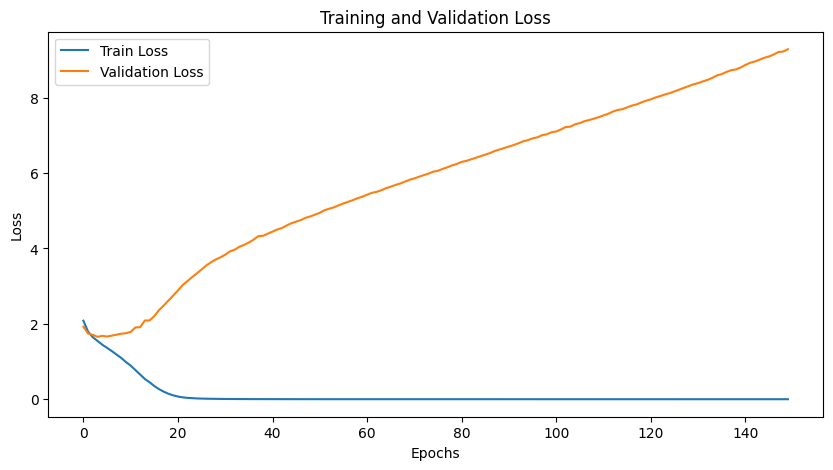

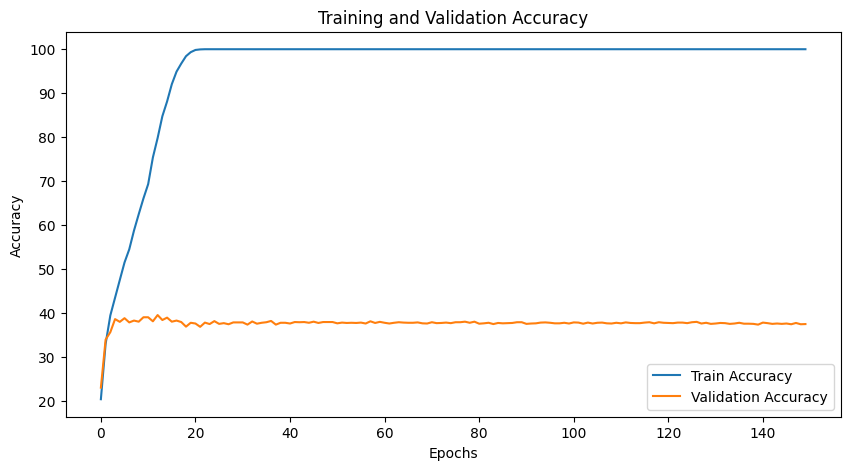

In [57]:
import matplotlib.pyplot as plt

history = torch.load('history_500_epoch_simple.pth')

plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [24]:
import pandas as pd

df_history = pd.DataFrame(history)
df_history.to_csv('wave_150_training_history.csv', index=False)

MobileNetV2 model Transfer Learning

In [28]:
from torchvision import transforms, models

In [46]:
class MusicGenreTransferModel(nn.Module):
    def __init__(self, num_classes=10):
        super(MusicGenreTransferModel, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.mobilenet.classifier[1] = nn.Linear(self.mobilenet.last_channel, num_classes)
        
    def forward(self, x):
        x = self.mobilenet(x)
        return x

In [37]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

In [47]:
model = MusicGenreTransferModel().to(device)

# Freeze the pre-trained layers
for param in model.mobilenet.features.parameters():
    param.requires_grad = False

/Users/shenpoheng/opt/anaconda3/envs/py39_native/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/shenpoheng/opt/anaconda3/envs/py39_native/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_dataset = MusicGenreDataset(test, transform)
train_dataset = MusicGenreDataset(train, transform)
val_dataset = MusicGenreDataset(val, transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Training loop
num_epochs = 150
train_losses = []
val_losses = []
train_acc = []
val_acc = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_val_loss = 0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = total_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_acc.append(train_accuracy)

    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()


    val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_accuracy:.2f}%')

    # Save the model's weights every 30 epochs
    if (epoch + 1) % 30 == 0:
        checkpoint_name = f'model_transfer_checkpoint_epoch{epoch + 1}.pth'
        torch.save(model.cpu().state_dict(), checkpoint_name)
        model.to(device)  # Move the model back to the GPU
        
        
torch.save(model.state_dict(), 'music_genre_model_transfer_learning.pth')
    
   

In [53]:
torch.save(model.state_dict(), 'wave_model_transfer_learning.pth')
# Save training history
history = {'train_loss': train_losses, 'val_loss': val_losses, 'train_acc': train_acc, 'val_acc': val_acc}
torch.save(history, 'wave_model_transfer_learning_history.pth')

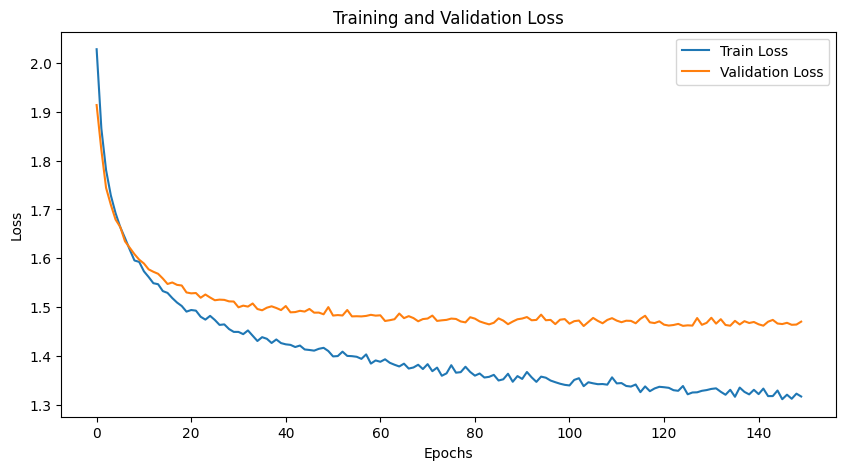

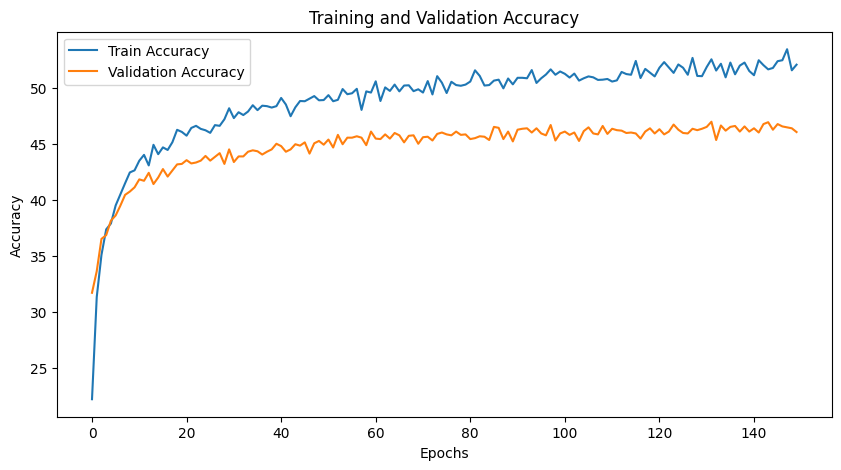

In [56]:
history = torch.load('wave_model_transfer_learning_history.pth')

plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('wave_model_transfer_learning_acc_plot.png')
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('wave_model_transfer_learning_loss_plot.png')
plt.show()

In [59]:
# Define a custom dataset class for your data
class MusicGenreDataset(Dataset):
    def __init__(self, img_paths, transform=None):
        self.data = self.get_data(img_paths)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

    def get_data(self, paths):
        data = []
        for index, path in enumerate(paths):
            print(f"now reading in: {index + 1}/{len(paths)}")
            label_index = LABELS.index(path.split("/")[-2])
            try:
                img_arr = cv2.imread(path)[...,::-1]  # Convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))  # Reshaping images to preferred size
                data.append([resized_arr, label_index])
            except Exception as e:
                print(e)
        return data

In [60]:
# Define cnn model
class MusicGenreModel(nn.Module):
    def __init__(self):
        super(MusicGenreModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * (IMG_SIZE // 4) * (IMG_SIZE // 4), 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * (IMG_SIZE // 4) * (IMG_SIZE // 4))
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [61]:
def split_dataset(image_paths):
  # Step 1: Calculate the total number of images
  total_images = len(image_paths)

  # Step 2: Calculate the number of images for each split
  train_ratio = 0.6
  val_ratio = 0.3
  test_ratio = 0.1

  num_train = int(total_images * train_ratio)
  num_val = int(total_images * val_ratio)
  num_test = int(total_images * test_ratio)

  # Step 3: Randomly shuffle the list of file paths
  random.shuffle(image_paths)

  # Step 4: Split the shuffled list of file paths
  image_paths_train = image_paths[:num_train]
  image_paths_val = image_paths[num_train:num_train + num_val]
  image_paths_test = image_paths[num_train + num_val:]


  return image_paths_train, image_paths_val, image_paths_test

In [62]:
data_dir = 'Data/wave/'

image_paths = get_png_file_paths(data_dir)
train, val, test = split_dataset(image_paths)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_dataset = MusicGenreDataset(test, transform)
train_dataset = MusicGenreDataset(train, transform)
val_dataset = MusicGenreDataset(val, transform)

In [64]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [65]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

In [ ]:
# Create an instance of the model (same as before)
model = MusicGenreModel().to(device)


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [ ]:

for lr in [0.005, 0.001, 0.0005, 0.0001, 0.00005]:
    # Create an instance of the model (same as before)
    model = MusicGenreModel().to(device)


    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    num_epochs = 100
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_acc.append(train_accuracy)

        # Validation loop
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                running_loss += loss.item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_acc.append(val_accuracy)

        print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_accuracy:.2f}%')

        # Save the model's weights every 30 epochs
        if (epoch + 1) % 30 == 0:
            checkpoint_name = f'model_checkpoint_epoch{epoch + 1}.pth'
            torch.save(model.cpu().state_dict(), checkpoint_name)
            model.to(device)  # Move the model back to the GPU
            
    # Save the model's weights
    torch.save(model.state_dict(), f'wave_CNN_epoch_{lr}_lr.pth')
    # Save training history
    history = {'train_loss': train_losses, 'val_loss': val_losses, 'train_acc': train_acc, 'val_acc': val_acc}
    torch.save(history, f'history_wave_CNN_epoch_{lr}_lr.pth')

    history = torch.load(f'history_wave_CNN_epoch_{lr}_lr.pth')

    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'wave_CNN_acc_plot_{lr}.png')
    plt.show()


    plt.figure(figsize=(10, 5))
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'wave_CNN_loss_plot_{lr}.png')
    plt.show()

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MusicGenreBatchNormModel(nn.Module):
    def __init__(self, input_shape):
        super(MusicGenreBatchNormModel, self).__init__()

        self.conv1 = nn.Conv2d(input_shape[0], 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv3 = nn.Conv2d(32, 32, kernel_size=2, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)

        self.conv4 = nn.Conv2d(32, 16, kernel_size=1, padding=1)
        self.bn4 = nn.BatchNorm2d(16)
        self.pool4 = nn.MaxPool2d(kernel_size=1, stride=2, padding=0)

        # Calculate the flattened size after the conv and pooling layers
        self.flattened_size = self._get_conv_output(input_shape)

        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 10)


    def _get_conv_output(self, shape):
        with torch.no_grad():
            input = torch.rand(1, *shape)
            output = self._forward_features(input)
            return int(np.prod(output.size()))  # Use np.prod to get the product of all dimensions

    def _forward_features(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Example usage
# input_shape = (3, IMG_HEIGHT, IMG_WIDTH)
# model = MusicGenreModel(input_shape)
# model.summary()  # PyTorch does not have a direct equivalent to Keras' model.summary()

In [69]:
def split_dataset(image_paths):
  # Step 1: Calculate the total number of images
  total_images = len(image_paths)

  # Step 2: Calculate the number of images for each split
  train_ratio = 0.6
  val_ratio = 0.3
  test_ratio = 0.1

  num_train = int(total_images * train_ratio)
  num_val = int(total_images * val_ratio)
  num_test = int(total_images * test_ratio)

  # Step 3: Randomly shuffle the list of file paths
  random.shuffle(image_paths)

  # Step 4: Split the shuffled list of file paths
  image_paths_train = image_paths[:num_train]
  image_paths_val = image_paths[num_train:num_train + num_val]
  image_paths_test = image_paths[num_train + num_val:]


  return image_paths_train, image_paths_val, image_paths_test

In [70]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

In [ ]:

IMG_HEIGHT, IMG_WIDTH = 256, 256
for data_dir in ['Data/spectromgram/', 'Data/chroma/', 'Data/wave/']:
    graph_type = data_dir.split('/')[-2]
    print(graph_type)
    image_paths = get_png_file_paths(data_dir)
    train, val, test = split_dataset(image_paths)

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    test_dataset = MusicGenreDataset(test, transform)
    train_dataset = MusicGenreDataset(train, transform)
    val_dataset = MusicGenreDataset(val, transform)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

    # Create an instance of the model (same as before)
    model = MusicGenreBatchNormModel((3, IMG_HEIGHT, IMG_WIDTH)).to(device)


    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Training loop
    num_epochs = 100
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_acc.append(train_accuracy)

        # Validation loop
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                running_loss += loss.item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_acc.append(val_accuracy)

        print(f'{graph_type} Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_accuracy:.2f}%')

        # Save the model's weights every 30 epochs
        if (epoch + 1) % 30 == 0:
            checkpoint_name = f'model_checkpoint_epoch{epoch + 1}{graph_type}.pth'
            torch.save(model.cpu().state_dict(), checkpoint_name)
            model.to(device)  # Move the model back to the GPU
        
    # Save the model's weights
    torch.save(model.state_dict(), f'{graph_type}_CNN_Batch_Norm_epoch_.pth')
    # Save training history
    history = {'train_loss': train_losses, 'val_loss': val_losses, 'train_acc': train_acc, 'val_acc': val_acc}

    torch.save(history, f'history_{graph_type}_CNN_Batch_Norm_epoch.pth')



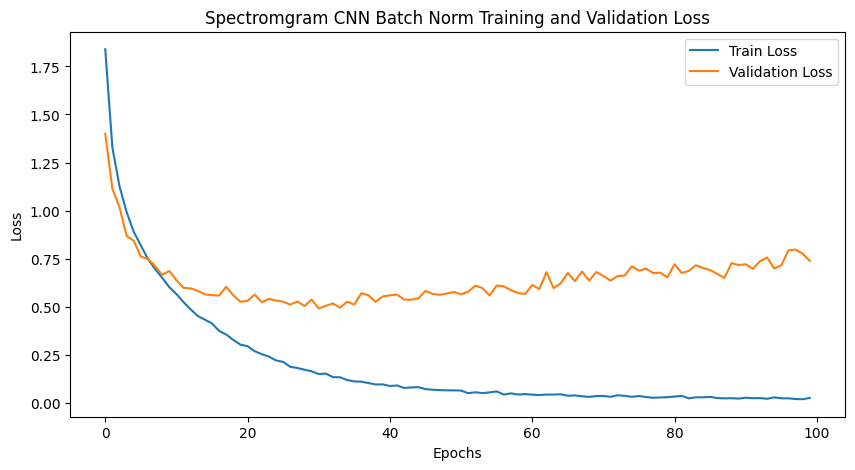

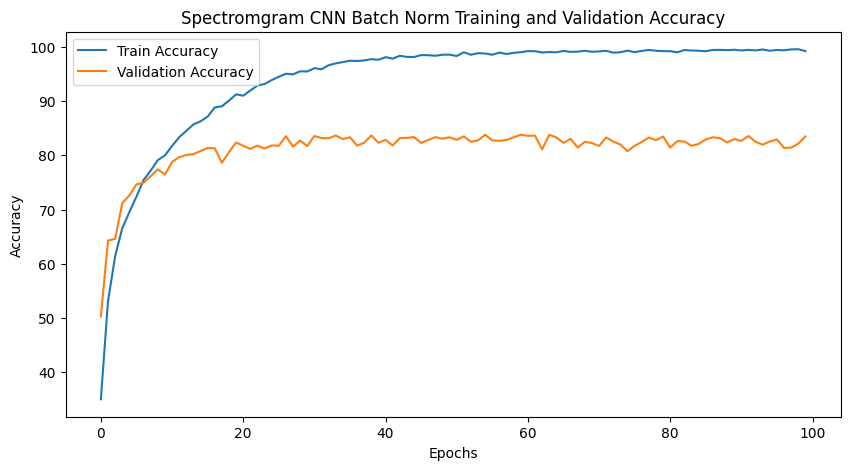

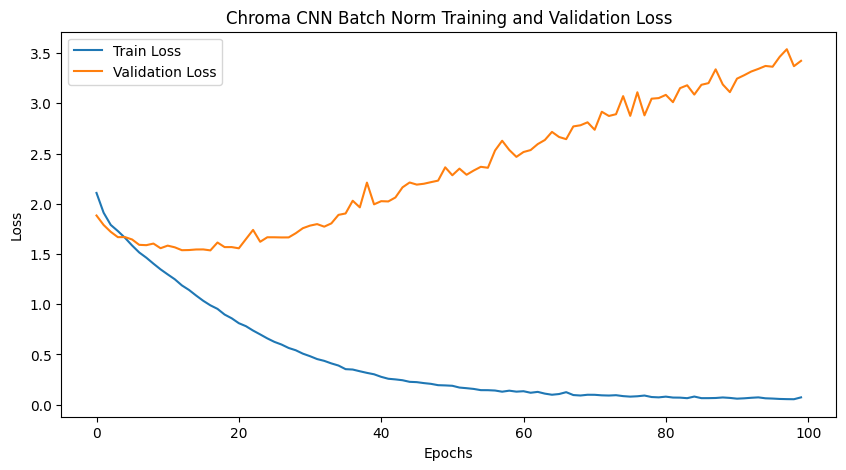

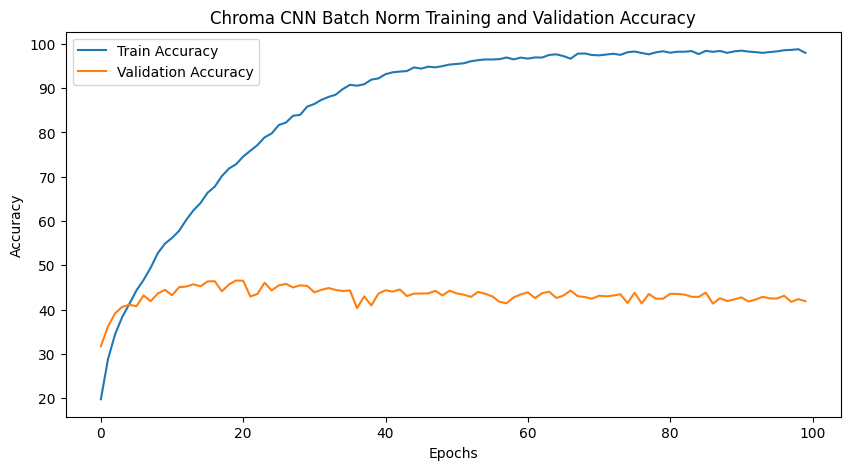

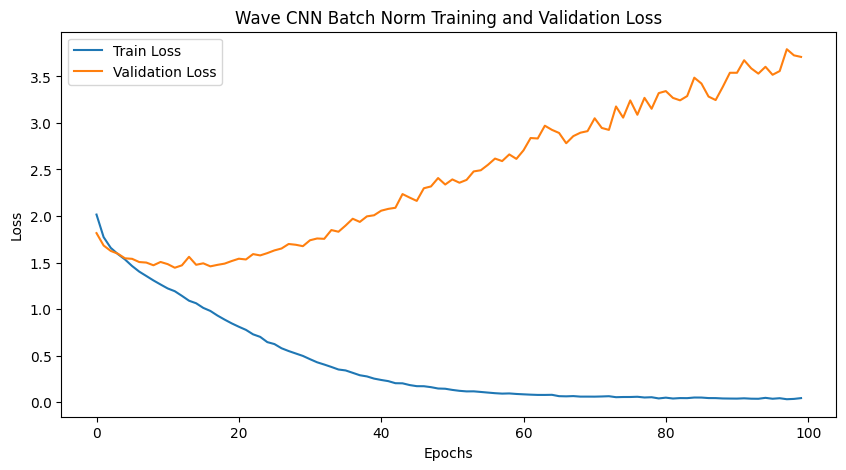

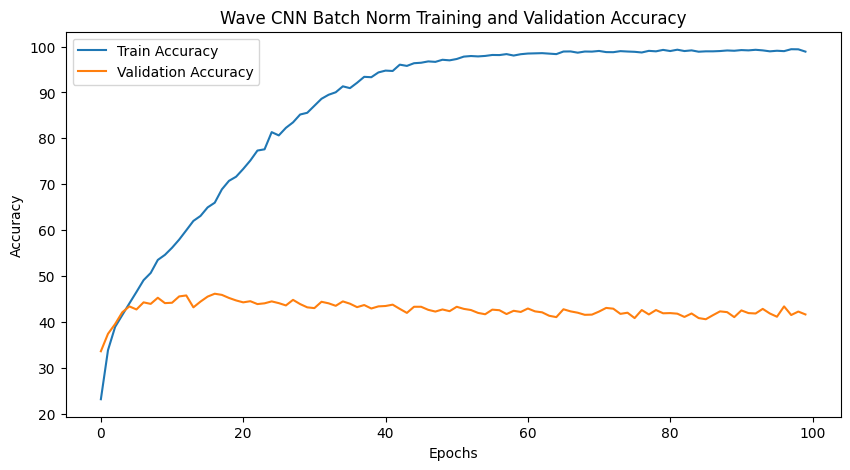

Max Validation Accuracy for Spectromgram: 83.80%
Max Validation Accuracy for Chroma: 46.59%
Max Validation Accuracy for Wave: 46.16%


In [94]:

max_val_accuracies = {}

for graph_type in ['Spectromgram', 'Chroma', 'Wave']:
    history = torch.load(f'history_{graph_type}_CNN_Batch_Norm_epoch.pth')

    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{graph_type} CNN Batch Norm Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'{graph_type} CNN Batch Norm Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    max_val_acc = max(history['val_acc'])
    max_val_accuracies[graph_type] = max_val_acc

for graph_type, max_val_acc in max_val_accuracies.items():
    print(f"Max Validation Accuracy for {graph_type}: {max_val_acc:.2f}%")